# Monte Carlo Simulation

In [54]:
import sys
import random
import matplotlib.pyplot as plt

In [55]:
#Import Modules and define functions

In [56]:
def read_to_list(file_name):
    """Open a file of data in percent, convert to a decimal and return a list"""
    with open(file_name) as in_file:
        lines = [float(line.strip()) for line in in_file]
        decimal = [round(line / 100, 5) for line in lines]
        return decimal
    
def default_input(prompt,default=None):
    """Allow use of default values in input."""
    prompt = '{} [{}]: '.format(prompt,default)
    response = input(prompt)
    if not response and default:
        return default
    else:
        return response

In [57]:
#Get User Input

In [58]:
#Load Data with original data in percent form
print("\nNote: Input data should be in percent, not decimal!\n")
try:
    bonds = read_to_list('10-yr_Tbond_returns_1926-2013_pct.txt')
    stocks = read_to_list('SP500_returns_1926-2013_pct.txt')
    blend_40_50_10 = read_to_list('S-B-C_blend_1926-2013_pct.txt')
    blend_50_50 = read_to_list('S-B_blend_1926-2013_pct.txt')
    infl_rate = read_to_list('annual_infl_rate_1926-2013_pct.txt')
except IOError as e:
    print("{}. \nTerminating program.".format(e), file=sys.stderr)
    sys.exit(1)
    
#get user input; use dictionary for investment-type arguments
investment_type_args = {'bonds': bonds, 'stocks': stocks,
                       'sb_blend': blend_50_50, 'sbc_blend': blend_40_50_10}

#print input legend for user
print("    stocks = SP500")
print("     bonds = 10-yr Treasury Bond")
print("  sb_blend = 50% SP500/50% TBond")
print(" sbc_blend = 40% SP500/50% TBond/10% Cash\n")
print("Press ENTER to take default value shown in [brackets]. \n")

#get user input
invest_type = default_input("Enter investment type: (stocks, bonds, sb_blend,"\
                     " sbc_blend): \n", 'bonds').lower()
while invest_type not in investment_type_args:
    invest_type = input("Invalid investment. Enter investment type " \
                    "as listed in prompt: ")

start_value = default_input("Input starting value of investments: \n", \
                             '2000000')
while not start_value.isdigit():
    start_value = input("Invalid input! Input integer only: ")

withdrawal = default_input("Input annual pre-tax withdrawal" \
                            " (today's $): \n", '80000')
while not withdrawal.isdigit():
    withdrawal = input("Invalid input! Input integer only: ")

min_years = default_input("Input minimum years in retirement: \n", '18')
while not min_years.isdigit():
    min_years = input("Invalid input! Input integer only: ")

most_likely_years = default_input("Input most-likely years in retirement: \n",
                                  '25')
while not most_likely_years.isdigit():
    most_likely_years = input("Invalid input! Input integer only: ")

max_years = default_input("Input maximum years in retirement: \n", '40')
while not max_years.isdigit():
    max_years = input("Invalid input! Input integer only: ")
    
num_cases = default_input("Input number of cases to run: \n", '50000')
while not num_cases.isdigit():
    num_cases = input("Invalid input! Input integer only: ")
    
#check for erronues input
if not int(min_years) < int(most_likely_years) < int(max_years) \
    or int(max_years) > 99:
    print("\nProblem with input years.", file=sys.stderr)
    print("Requires Min < ML < Max with Max <= 99.", file=sys.stderr)
    sys.exit(1)


Note: Input data should be in percent, not decimal!

    stocks = SP500
     bonds = 10-yr Treasury Bond
  sb_blend = 50% SP500/50% TBond
 sbc_blend = 40% SP500/50% TBond/10% Cash

Press ENTER to take default value shown in [brackets]. 

Enter investment type: (stocks, bonds, sb_blend, sbc_blend): 
 [bonds]: bonds
Input starting value of investments: 
 [2000000]: 20000
Input annual pre-tax withdrawal (today's $): 
 [80000]: 0
Input minimum years in retirement: 
 [18]: 10
Input most-likely years in retirement: 
 [25]: 15
Input maximum years in retirement: 
 [40]: 25
Input number of cases to run: 
 [50000]: 3000


In [59]:
#Define Monte Carlo Engine

In [60]:
def montecarlo(returns):
    """Run MCS and return investment value at end-of-plan and bankrupt count,"""
    case_count = 0
    bankrupt_count = 0
    outcome = []
    
    while case_count < int(num_cases):
        investments = int(start_value)
        start_year = random.randrange(0, len(returns))
        duration = int(random.triangular(int(min_years), int(max_years), int(most_likely_years)))
        end_year = start_year + duration
        lifespan = [i for i in range(start_year, end_year)]
        bankrupt = 'no'
        
        #temp list for each case
        lifespan_returns = []
        lifespan_infl = []
        for i in lifespan:
            lifespan_returns.append(returns[i % len(returns)])
            lifespan_infl.append(infl_rate[i % len(infl_rate)])
            
        for index, i in enumerate(lifespan_returns):
            infl = lifespan_infl[index]
    
            if index == 0:
                withdraw_infl_adj = int(withdrawal)
            else:
                withdraw_infl_adj = int(withdraw_infl_adj * (1 + infl))
    
            investments -= withdraw_infl_adj
            investments = int(investments * (1 + i))
    
            if investments <= 0:
                bankrupt = 'yes'
                break
        
        if bankrupt == 'yes':
            outcome.append(0)
            bankrupt_count += 1
        else:
            outcome.append(investments)
    
        case_count += 1

    return outcome, bankrupt_count

In [61]:
#Calculating Probability of Ruin
def bankrupt_prob(outcome, bankrupt_count):
    """Calculate and return chance of running out of money and other stats."""
    total = len(outcome)
    odds = round(100 * bankrupt_count / total, 1)
    
    print("\n Investment Type: {}".format(invest_type))
    print("Starting value: ${:,}".format(int(start_value)))
    print("Annual Withdrawal: ${:,}".format(int(withdrawal)))
    print("Years of retirement (min-ml-max): {}-{}-{}".format(min_years, most_likely_years, max_years))
    print("Number of runs: {:,}\n".format(len(outcome)))
    print("Odds of running out of money: {}%\n".format(odds))
    print("Average outcome: ${:,}".format(int(sum(outcome) / total)))
    print("Minimum outcome: ${:,}".format(min(i for i in outcome)))
    print("Maximum outcome: ${:,}".format(max(i for i in outcome)))
    
    return odds


 Investment Type: bonds
Starting value: $20,000
Annual Withdrawal: $0
Years of retirement (min-ml-max): 10-15-25
Number of runs: 3,000

Odds of running out of money: 0.0%

Average outcome: $48,215
Minimum outcome: $21,617
Maximum outcome: $184,942


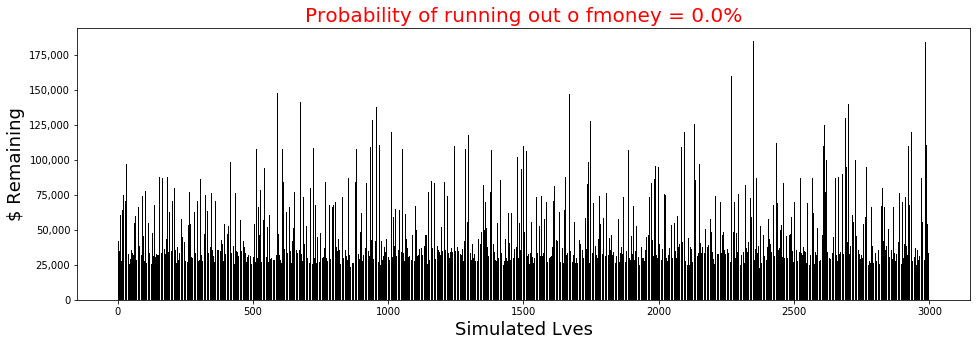

In [63]:
#Define Main Function
def main():
    """Call MCS & bankrupt functions and draw bar chart of results"""
    outcome, bankrupt_count = montecarlo(investment_type_args[invest_type])
    odds = bankrupt_prob(outcome, bankrupt_count)
    
    plotdata = outcome[:3000] #plot first 3000 runs
    
    plt.figure('Outcome by Case(showing first{} runs)'.format(len(plotdata)),figsize=(16,5)) #size in width, height in inches
    index = [i + 1 for i in range(len(plotdata))]
    plt.bar(index, plotdata, color ='black')
    plt.xlabel('Simulated Lves', fontsize = 18)
    plt.ylabel( '$ Remaining', fontsize = 18)
    plt.ticklabel_format(style='plain', axis = 'y')
    ax = plt.gca()
    ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
    plt.title('Probability of running out of money = {}%'.format(odds),fontsize=20, color='red')
    plt.show
#run program
if __name__ == '__main__':
    main() 